### import

In [1]:
import ast
import wfdb
import h5py

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.decomposition import PCA         
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb  

### 데이터 읽기
- input 요소 있음. 콜렙은 c, 데스크탑은 D, 서버에서는 s 라고 치면됨. 대문자 소문자 상관없음.

In [2]:
res = os.getcwd()
base_path = os.path.join(res)
base_path_ptb = os.path.join(res, 'ptb_xl_data') + '/'
base_path_shp = os.path.join(res, 'sph_data') + '/'

In [3]:
df_ptb_origin = pd.read_csv(base_path_ptb + 'ptbxl_database.csv', encoding='utf-8',index_col='ecg_id')
df_sph_origin = pd.read_csv(base_path_shp + 'metadata.csv', encoding='utf-8', index_col='ECG_ID')

In [4]:
df_ptb_lead1 = pd.read_csv(base_path + '/custom_file/ashton_ptb_lead1.csv', index_col=0)

df_sph_lead1 = pd.read_csv(base_path + '/custom_file/ashton_sph_lead1.csv', index_col=0)

### PTB_xl, SHP 데이터 라벨링

In [5]:
#PTB 라벨링

#scp_codes 에서 AFIB에 해당하는 것에 대해서 라벨링
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: list(x.keys()))
df_ptb_origin['label'] = df_ptb_origin.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

print('df_ptb_origin : ',df_ptb_origin.label.value_counts())
print('-'*15)

#SHP 라벨링

# df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(lambda x: 1 if '50' in str(x) else 0) - 기존에 잘못된
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(check_contains_50).astype(int)


print('df_sph_origin : ',df_sph_origin.label.value_counts())

df_ptb_origin :  label
0    20285
1     1514
Name: count, dtype: int64
---------------
df_sph_origin :  label
0    25095
1      675
Name: count, dtype: int64


### age, sex, label 컬럼과 심박수 데이터 합치기

In [6]:
df_ptb = pd.concat([df_ptb_origin[['age', 'sex', 'label']], df_ptb_lead1], axis=1)

df_sph_lead1.index = df_sph_origin.index
df_sph = pd.concat([df_sph_origin[['Age', 'Sex', 'label']], df_sph_lead1], axis=1)


In [7]:

# df_ptb와 df_sph에 있는 데이터를 가져와서 처리
X_ptb = df_ptb.drop(['age', 'sex', 'label'], axis=1)
y_ptb = df_ptb['label'].values

X_sph = df_sph.drop(['Age', 'Sex', 'label'], axis=1)
y_sph = df_sph['label'].values


In [ ]:
pip install librosa

In [14]:
import librosa
import librosa.display


In [16]:
save_dir = base_path + '/custom_file/X_ptb_lead1_Spectrogram'
os.makedirs(save_dir, exist_ok=True)


for i in range(len(X_ptb)):
    D = np.abs(librosa.stft(X_ptb.values[i]))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')
    plt.axis('off') 
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

OSError: cannot load library 'libsndfile.so': libsndfile.so: cannot open shared object file: No such file or directory

KeyboardInterrupt: 

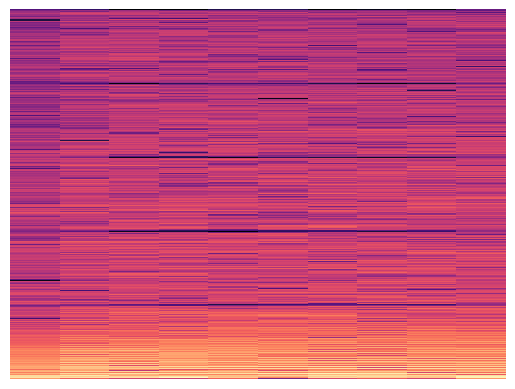

In [ ]:
save_dir = base_path + '/custom_file/X_sph_lead1_Spectrogram'
os.makedirs(save_dir, exist_ok=True)


for i in range(len(X_sph)):
    D = np.abs(librosa.stft(X_sph.values[i]))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
    file_path = os.path.join(save_dir, f'sph_lead1_{i:05d}.png')
    plt.axis('off') 
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

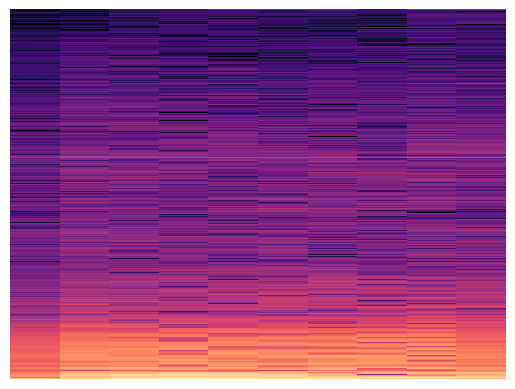

In [26]:
data = X_ptb.values[1]

D = np.abs(librosa.stft(data))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
plt.axis('off') 
plt.show()

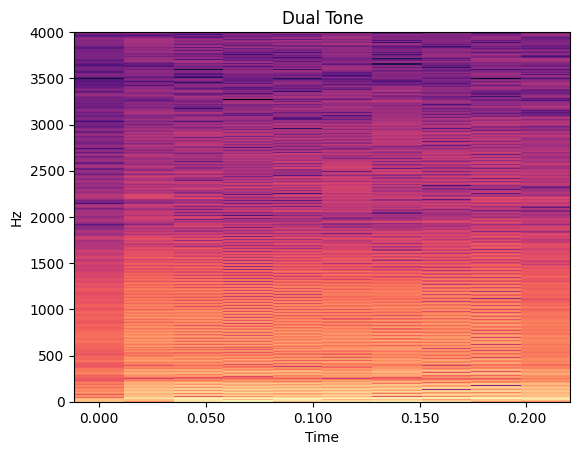

In [10]:
data = X_ptb.values[1]

D = np.abs(librosa.stft(data))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
plt.title('Dual Tone')
plt.ylim(0, 4000)
plt.show()

In [63]:
fs = 16000

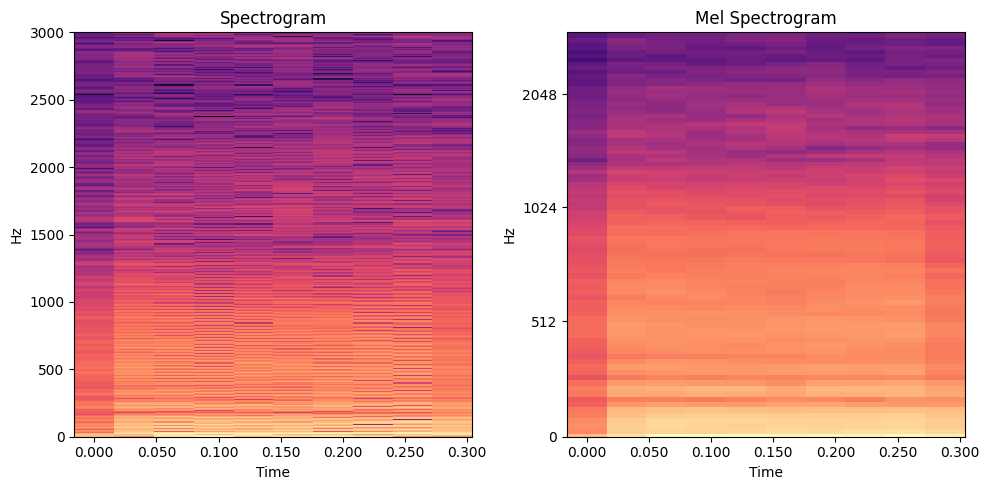

In [66]:
data = X_ptb.values[1]
plt.figure(figsize=(10,5))

plt.subplot(121)
d_stft = np.abs(librosa.stft(data))
librosa.display.specshow(librosa.amplitude_to_db(d_stft, ref=np.max), sr=fs, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.ylim(0, 3000)

plt.subplot(122)
d_msp = librosa.feature.melspectrogram(y=data, sr=fs, n_mels=128)
librosa.display.specshow(librosa.power_to_db(d_msp, ref=np.max), sr=fs, y_axis='mel', x_axis='time')
plt.ylim(0, 3000)
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# X_ptb의 0번 인덱스를 2D 배열로 변환
data = X_ptb.iloc[0].values.reshape(1, -1)

# 스펙트로그램 생성
D = librosa.amplitude_to_db(np.abs(librosa.stft(data, hop_length=512)), ref=np.max)

# 데이터의 shape 확인
print("Data shape:", data.shape)
print("Spectrogram shape:", D.shape)

# 시각화
librosa.display.specshow(D, sr=fs, y_axis='linear', x_axis='time')
plt.title('Spectrogram of Heart Rate Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


Data shape: (1, 5000)
Spectrogram shape: (1, 1025, 10)


ZeroDivisionError: float division by zero

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# 가상의 심박수 데이터 생성 (예시 데이터, 실제 데이터로 대체해야 함)
fs = 1000  # 샘플 레이트
duration = 10  # 데이터의 길이 (초)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
heart_rate = 60 + 10 * np.sin(2 * np.pi * 1 * t)  # 가상의 심박수 데이터 생성

# 스펙트로그램 생성
D = librosa.amplitude_to_db(np.abs(librosa.stft(heart_rate)), ref=np.max)

# 시각화
librosa.display.specshow(D, sr=fs, y_axis='linear', x_axis='time')
plt.title('Spectrogram of Heart Rate Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

ZeroDivisionError: float division by zero

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# 가상의 심박수 데이터 생성 (예시 데이터, 실제 데이터로 대체해야 함)
fs = 1000  # 샘플 레이트
duration = 10  # 데이터의 길이 (초)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
heart_rate = 60 + 10 * np.sin(2 * np.pi * 1 * t)  # 가상의 심박수 데이터 생성

# 스펙트로그램 생성
d_stft = X_ptb.values[0]
librosa.display.specshow(librosa.amplitude_to_db(d_stft, ref=np.max), sr=fs, y_axis='linear', x_axis='time')
plt.title('Spectrogram of Heart Rate Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


IndexError: tuple index out of range

In [ ]:
save_dir = base_path + '/custom_file/ptb_lead1_image'
os.makedirs(save_dir, exist_ok=True)

for i in range(len(X_ptb)):
    X_train_data = X_ptb.values[i]
    heart_rate_data_2d = X_train_data.reshape(-1, 1)

    # 이미지를 파일로 저장할 경로 설정
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')

    # 이미지 저장
    plt.imshow(heart_rate_data_2d.T, cmap='viridis', aspect='auto')  # viridis 컬러맵 사용
    plt.axis('off')  # x축 및 y축 숨김
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [100]:
save_dir = base_path + '/custom_file/ptb_lead1_image'
os.makedirs(save_dir, exist_ok=True)

# for i in range(len(X_ptb)):
for i in range(3):
    X_train_data = X_ptb.values[i]
    heart_rate_data_2d = X_train_data.reshape(-1, 1)

    # 이미지를 파일로 저장할 경로 설정
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')

    # 빈도수 계산
    frequencies, bins = np.histogram(X_train_data, bins=50)  # 예시로 50개의 빈으로 나눔
    bin_centers = (bins[1:] + bins[:-1]) / 2

    # 각 값에 대한 빈도수에 따라 색상 선택
    colors = plt.cm.viridis(frequencies / float(max(frequencies)))

    # 이미지 저장
    plt.figure(figsize=(10, 5))
    plt.scatter(bin_centers, np.ones_like(bin_centers) * 0.5, c=colors, s=100, marker='|')
    plt.axis('off')  # x축 및 y축 숨김
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [71]:
X_ptb.values[1]

array([-0.015, -0.015, -0.015, ..., -0.055, -0.055, -0.055])

In [68]:
data = X_ptb.values[1]

KeyboardInterrupt: 

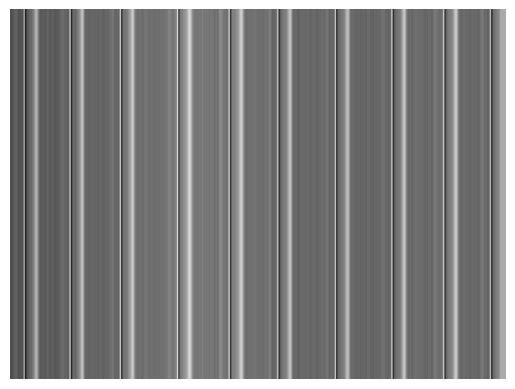

In [101]:
save_dir = base_path + '/custom_file/ptb_lead1_image'
os.makedirs(save_dir, exist_ok=True)

for i in range(len(X_ptb)):
    X_train_data = X_ptb.values[i]
    heart_rate_data_2d = X_train_data.reshape(-1, 1)

    # 이미지를 파일로 저장할 경로 설정
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')

    # 이미지 저장
    plt.imshow(heart_rate_data_2d.T, cmap='gray', aspect='auto')
    plt.axis('off')  # x축 및 y축 숨김
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [ ]:
save_dir = base_path + '/custom_file/sph_lead1_image'
os.makedirs(save_dir, exist_ok=True)

for i in range(len(X_ptb)):
    X_sph_test_data = X_sph.values[i]
    heart_rate_data_2d = X_sph_test_data.reshape(-1, 1)

    # 이미지를 파일로 저장할 경로 설정
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')

    # 이미지 저장
    plt.imshow(heart_rate_data_2d.T, cmap='gray', aspect='auto')
    plt.axis('off')  # x축 및 y축 숨김
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()

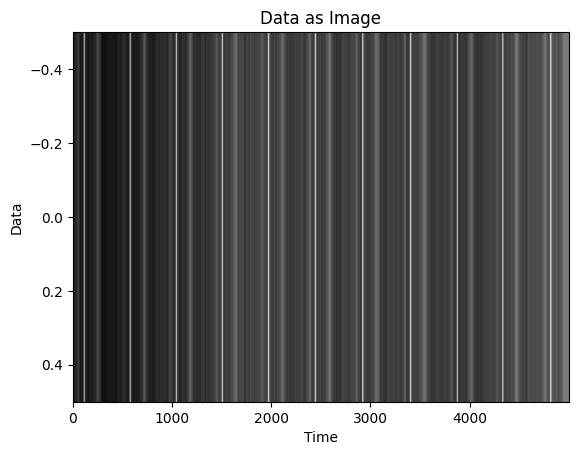

In [55]:


# 주어진 X_train 데이터 (실제 데이터에 대체해야 함)
X_train_data = X_ptb.values[0]  # 0번 인덱스의 데이터만 선택

# 데이터를 2D 배열로 변환 (예시에서는 간단하게 2D 배열로 변환하였습니다.)
# 여러 방법으로 데이터를 2D 배열로 변환할 수 있습니다.
heart_rate_data_2d = X_train_data.reshape(-1, 1)

# 이미지로 시각화
plt.imshow(heart_rate_data_2d.T, cmap='gray', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Data as Image')
plt.show()